# TMD maps with one-D potential 

Here we will aim to measure the effect of prefactor reduction in a 1D case of TMD map. Note that our error model is of the form: 

$$ |4L^{(n)}_{\epsilon,\mu}f(x) - \mathcal{L}f(x)| \sim \frac{V(x)\sqrt{\log n}}{\sqrt{n}\epsilon^{2 + d/2}} + \epsilon B(x) $$

Here $V$ and $B$ are variance and bias error prefactors respectively. The 1-D setup is as follows: 

1. $V: \mathbb{R} \to \mathbb{R}$ is a (coercive) potential. 
2. The system $X_t$ is governed by the SDE: 
$\begin{align}dX_t = -\nabla V(X_t) + \sqrt{2\beta^{-1}} dW_t \end{align} $
3. The ergodic measure is $\propto \exp{\left(-\beta V(x)\right)}$
4. The committor satisfies: 
$$\begin{align}\Delta q - \beta\nabla V(x) \cdot \nabla q(x) = 0,\:\: q\mid_{\partial A} = 0\, q\mid_{\partial B} = 1 \end{align}$$

Here $A = \{x < a\}$, $B = \{x > b\}$. The committor function can be given analytically for $x \in (a,b)$: 

$$ q(x) = \frac{\int_{a}^{x}\exp{\left(-\beta V(x)\right)}\,dy}{\int_{a}^{b}\exp{\left(-\beta V(y)\right)}\,dy}$$

A good 1-D potential is 

$$ V(x) = (x^2 - 1)^2 $$

We set 

$$ A = \{x < -0.8 \}, \: B = \{x > -0.8 \}$$

In [1]:
import os
import copy
import sys 
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__),'..')))
sys.path.append("..")

# Regular Modules
import scipy.sparse as sps
import numpy as np
import sklearn as sklearn
import matplotlib.pyplot as plt
import datetime
import scipy.integrate as scint
#from numpy.random import default_rng
import numpy.ma as ma
import matplotlib.tri as tri
import scipy.io
import time 
from mpl_toolkits.mplot3d import axes3d
import argparse

# parallelization modules 
from math import nan
from joblib import Parallel, delayed
import multiprocess
import itertools
import tqdm

# # My Modules
import src.model_systems as model_systems
import src.helpers as helpers
import src.potentials as potentials
import src.diffusion_map as diffusion_map
from src.fem.distmesh import * 
from src.fem.FEM_TPT import *
import src.sampling as sampling
from datetime import date

In [116]:
import scipy.sparse as sps

How to do this: 

1. Set up drift, potential, invariant measure, committor. 

2. Set up two datasets: uniform, normal random variable centered @ 0. 

3. Set up TMD map kernel for each set. This will involve picking epsilon, N. Don't use knn sparsification. Compare KDE's. 

4. Approximate $\mathcal{L}$ on some simple $f$ (say $f = x^5 - x$) by plugging in the analytical form for $\mathcal{L}f = f'' - V'(x)f'(x)$.

5. Note that $4\mathcal{L}_{\epsilon,\mu}f(x) \approx \mathcal{L}$. DONT FORGET THE FACTOR OF 4!!!

In [2]:
# set up params
beta = 1
d = 1
def potential(x): 
    return (x**2 - 1)**2 

def drift(x): 
    return 4*x*(x**2 - 1)

Z = scint.quad(lambda x: np.exp(-beta*potential(x)), -50, 50)[0]

def mu(x): return (1/Z)*np.exp(-beta*potential(x))

In [76]:
def f(x): return np.sin(2*np.pi*x)
def Lf(x): return -4*(np.pi**2)*np.sin(2*np.pi*x) - beta*4*x*(x**2-1)*(2*np.pi*np.cos(2*np.pi*x))
Z_committor = scint.quad(lambda x: np.exp(beta*potential(x)), -0.9,0.9)[0]

def committor(x):
    if x < -0.9: 
        return 0.0
    elif x > 0.9:
        return 1.0
    else: 
        return (1/Z_committor)*scint.quad(lambda y: np.exp(beta*potential(y)), -0.9,x)[0]

In [117]:
def construct_L(epsilon, target_measure, K, inds):
        r""" Construct the generator approximation corresponding to input data
        
        Parameters
        ----------
        data: array (num features, num samples)
        
        """  

        N = K.shape[-1]
        
        
        q = np.array(K.sum(axis=1)).ravel()
        q_inv = np.power(q, -1) 
        Q_inv = sps.spdiags(q_inv, 0, N, N)

        # Multiply by target measure and right-normalize
        pi = np.power(target_measure, 0.5) 
        Pi = sps.spdiags(pi, 0, N, N)
        Q_inv = Q_inv.dot(Pi)
        K_rnorm = K.dot(Q_inv)
        
        # reindex based on specification
        K_rnorm = K_rnorm[inds, inds]
        N = K_rnorm.shape[-1]
        
        # Make left normalizing vector 
        q = np.array(K_rnorm.sum(axis=1)).ravel()
        q_alpha = np.power(q, -1)
        D_alpha = sps.spdiags(q_alpha, 0, N, N)
        P = D_alpha.dot(K_rnorm)

        # Transform Markov Matrix P to get discrete generator L 
        L = (P - sps.eye(N, N))/epsilon

        return L

In [112]:
# set up dataset for uniform estimation 
# ϵ_uniform = 1/(10**(4/5))
ϵ_uniform = 1/(10**(4/3))
N = int(1e4)
# uniform = np.linspace(-2,2,int(N+1)).reshape(N+1,d) # note that p = uniform[0,N/2]
uniform = np.random.uniform(-4.0,4.0,N+1).reshape(N+1,d)
uniform[N,0] = 0.0
target_measure_uniform = np.zeros(N+1)

for i in range(N+1):
    target_measure_uniform[i] = mu(uniform[i,:])

target_dmap_uniform = diffusion_map.TargetMeasureDiffusionMap(epsilon=ϵ_uniform, n_neigh=int(N), \
                                                          target_measure=target_measure_uniform)
target_dmap_uniform.construct_generator(uniform.T)
K_uniform = target_dmap_uniform.get_kernel()
# L_uniform = target_dmap_uniform.get_generator() 

In [118]:
inds = np.where(np.abs(uniform) <= 3)[0]

In [119]:
L = construct_L(ϵ_uniform, target_measure_uniform, K_uniform, inds)

ValueError: dimension mismatch

In [8]:
# set up dataset for biased estimation 

N = int(1e4)
ϵ_biased = 1/(10**(4/5))
biased = np.random.randn(int(N+1)).reshape(N+1,d) # p = biased[N]
biased[N,0] = 0.0
target_measure_biased = np.zeros(N+1)
for i in range(N+1):
    target_measure_biased[i] = mu(biased[i,:])

target_dmap_biased = diffusion_map.TargetMeasureDiffusionMap(epsilon=ϵ_biased, n_neigh=int(N), \
                                                          target_measure=target_measure_biased)
target_dmap_biased.construct_generator(biased.T)
K_biased = target_dmap_biased.get_kernel()
L_biased = target_dmap_biased.get_generator() 

In [4]:
def f(x): return x**6 - x 
def Lf(x): return 30*(x**4) - beta*4*x*(x**2-1)*(6*(x**5) - 1)

In [5]:
Z_committor = scint.quad(lambda x: np.exp(beta*potential(x)), -0.9,0.9)[0]

def committor(x):
    if x < -0.9: 
        return 0.0
    elif x > 0.9:
        return 1.0
    else: 
        return (1/Z_committor)*scint.quad(lambda y: np.exp(beta*potential(y)), -0.9,x)[0]

# Testing on pointwise estimates

## Uniform 

In [106]:
full_uniform = uniform 
uniform = uniform[np.where(np.abs(uniform) <= 3)]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [105]:
# derivative on uniform set 
# F_uniform = f(uniform)
# LF_uniform_true = Lf(uniform)
# LF_uniform_TMD = L_uniform@F_uniform 
F_uniform = np.apply_along_axis(f,1,uniform)
LF_uniform_true = np.apply_along_axis(Lf, 1, uniform)
LF_uniform_TMD = L_uniform@F_uniform

AxisError: axis 1 is out of bounds for array of dimension 1

(0.0, 1.0)

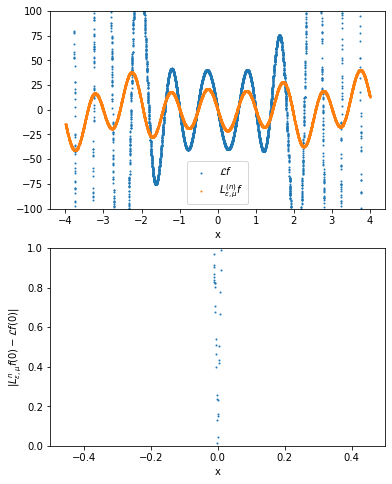

In [91]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8))
ax1.scatter(uniform, LF_uniform_true, s=1.0, label="$\mathcal{L}f$")
ax1.scatter(uniform, 4*LF_uniform_TMD, s=1.0, label="$L^{(n)}_{\epsilon,\mu}f$")
# ax1.set_xlim((-0.5,0.5))
ax1.set_ylim((-100,100))
ax1.set(xlabel="x")
ax1.legend()
ax2.scatter(uniform, np.abs(LF_uniform_true-4*LF_uniform_TMD), s=1.0)
ax2.set(xlabel="x", ylabel="$|L^{n}_{\epsilon,\mu}f(0) - \mathcal{L}f(0)|$")
ax2.set_xlim((-0.5,0.5))
ax2.set_ylim((0.0,1.0))

In [92]:
# check committor on uniform set 
committor_uniform = np.apply_along_axis(committor, 1, uniform)
# LF_uniform_true = Lf(uniform)
Lcommittor_uniform_TMD = L_uniform@committor_uniform 

(-0.05, 0.05)

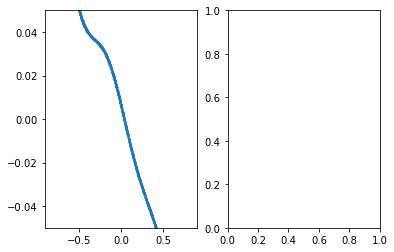

In [93]:
fig, (ax1, ax2) = plt.subplots(1,2)
# ax1.scatter(uniform, LF_uniform_true, s=1.0)
ax1.scatter(uniform, Lcommittor_uniform_TMD, s=1.0)
ax1.set_xlim((-0.9,0.9))
ax1.set_ylim((-0.05,0.05))
# ax2.scatter(uniform, np.abs(LF_uniform_true-4*LF_uniform_TMD), s=1.0)
# ax2.set_xlim((-0.5,0.5))

In [94]:
# checking KDE 
rho_epsilon_uniform = (1/(N+1))*(1/(np.pi*ϵ_uniform)**(d/2))*K_uniform@np.ones((N+1,1))

In [95]:
rho_epsilon_uniform

array([[0.12897199],
       [0.12511303],
       [0.11902737],
       ...,
       [0.12936918],
       [0.12442875],
       [0.12969746]])

In [96]:
uniform_rnd = (1/8)*np.ones(uniform.shape)

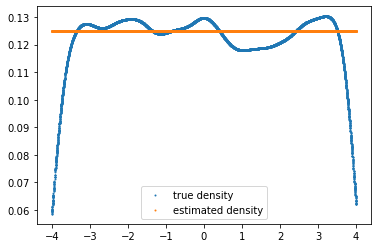

In [97]:
plt.scatter(uniform, rho_epsilon_uniform, s=1.0, label="true density")
plt.scatter(uniform, uniform_rnd, s=1.0, label="estimated density")
# plt.ylim((0.20,0.30))
# plt.xlim((-1.5,1.5))
plt.legend()

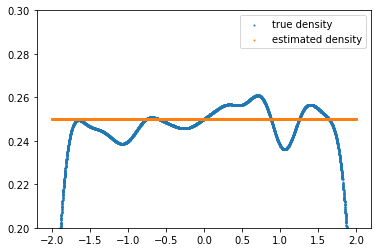

In [33]:
plt.scatter(uniform, rho_epsilon_uniform, s=1.0, label="true density")
plt.scatter(uniform, uniform_rnd, s=1.0, label="estimated density")
plt.ylim((0.20,0.30))
# plt.xlim((-1.5,1.5))
plt.legend()

(-0.01, 0.015)

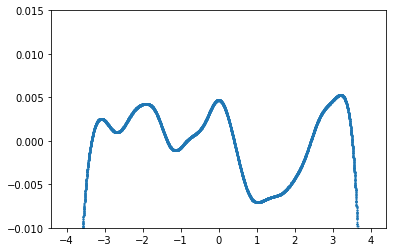

In [101]:
plt.scatter(uniform, rho_epsilon_uniform-uniform_rnd, s=1.0)
plt.ylim((-0.01,0.015))

In [103]:
np.where(np.abs(uniform) <= 3)

(array([    0,     1,     2, ...,  9998,  9999, 10000]),
 array([0, 0, 0, ..., 0, 0, 0]))

## Biased

In [35]:
# derivative on biased set 
F_biased = f(biased)
LF_biased_true = Lf(biased)
LF_biased_TMD = L_biased@F_biased

(0.0, 1.0)

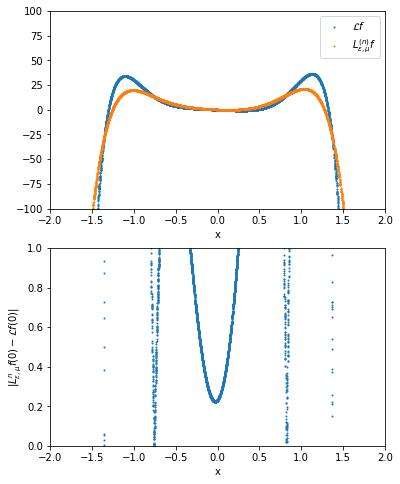

In [49]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,8))
ax1.scatter(biased, LF_biased_true, s=1.0, label="$\mathcal{L}f$")
ax1.scatter(biased, 4*LF_biased_TMD, s=1.0, label="$L^{(n)}_{\epsilon,\mu}f$")
ax1.set_xlim((-2.0,2.0))
ax1.set_ylim((-100,100))
ax1.set(xlabel="x")
ax1.legend()
ax2.scatter(biased, np.abs(LF_biased_true-4*LF_biased_TMD), s=1.0)
ax2.set(xlabel="x", ylabel="$|L^{n}_{\epsilon,\mu}f(0) - \mathcal{L}f(0)|$")
ax2.set_xlim((-2.0,2.0))
ax2.set_ylim((0,1.0))

In [85]:
# check committor on uniform set 
committor_biased = np.apply_along_axis(committor, 1, biased)
# LF_uniform_true = Lf(uniform)
Lcommittor_biased_TMD = L_biased@committor_biased

(-0.45, 0.45)

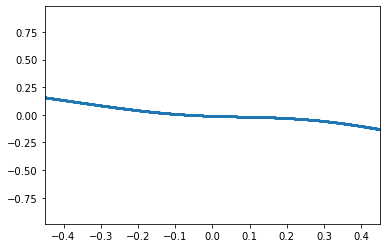

In [90]:
fig, ax1 = plt.subplots()
# ax1.scatter(uniform, LF_uniform_true, s=1.0)
ax1.scatter(biased, 4*Lcommittor_biased_TMD, s=1.0)
ax1.set_xlim((-0.45,0.45))
# ax2.scatter(uniform, np.abs(LF_uniform_true-4*LF_uniform_TMD), s=1.0)
# ax2.set_xlim((-0.5,0.5))

In [41]:
ϵ_biased

0.15848931924611132

In [42]:
# checking KDE 
rho_epsilon_biased = (1/(N+1))*(1/(np.pi*ϵ_biased)**(d/2))*K_biased@np.ones((N+1,1))

In [43]:
normal_rnd = (1/(2*np.pi)**(d/2))*np.exp(-(biased**2)/2)

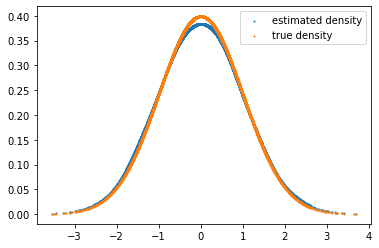

In [45]:
plt.scatter(biased, rho_epsilon_biased, s=1.0, label="estimated density")
plt.scatter(biased, normal_rnd, s=1.0, label="true density")
plt.legend()

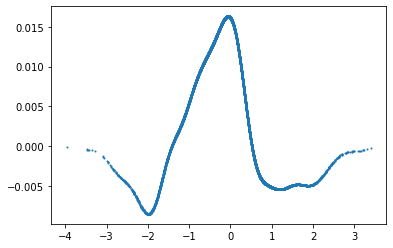

In [28]:
plt.scatter(biased, normal_rnd-rho_epsilon_biased, s=1.0)

Scaling law seems to be 2 + d/2! 

# Testing bias error 

Main idea: For each uniform/biased dataset do the following. Have a range of epsilons, and pick N according to the 1/2 + 0.5d scaling law. Then approximate f with the TMD map generator and compare error according to epsilon. Inshallah everything should lineup roughly along a line. 

## Uniform

In [9]:
# set up info 
epsilons = np.linspace(0.04, 0.06, 10)  # actual sim 
# epsilons = np.linspace(0.06, 0.07, 2)     # trial params for debug 
Ns_uniform = epsilons**(-3)
epsilons_range = len(epsilons)
ntrials = 12 # actual sim 
# ntrials = 1    # trial params for debug 
trial_ids = np.linspace(1,ntrials,ntrials)
# Lcommittor_uniform_TMD = np.zeros((epsilons_range, ntrials))

In [14]:
def task(t, regime="uniform"):
    # ϵ_uniform = epsilons_uniform[i]
    np.random.seed() 
    ϵ, _  = t
    N = int(ϵ**(-3))
    
    if regime=="uniform":
        data = np.random.uniform(-2.0,2.0,N+1).reshape(N+1,d)
    else:
        data = np.random.randn(int(N+1)).reshape(N+1,d)
    
    data[N,0] = 0.0
    target_measure = np.zeros(N+1)

    for i in range(N+1):
        target_measure[i] = mu(data[i,:])

    target_dmap = diffusion_map.TargetMeasureDiffusionMap(epsilon=ϵ, n_neigh=int(N), \
                                                              target_measure=target_measure)
    target_dmap.construct_generator(data.T)
    # print("Got kernel!")
    K = target_dmap.get_kernel()
    L = target_dmap.get_generator() 
    # check committor on uniform set 
    committor_data = np.apply_along_axis(committor, 1, data)
    # LF_uniform_true = Lf(uniform)
    Lcommittor_atzero = L[-1,:]@committor_data
    print("Got result!")
    return Lcommittor_atzero[0]

In [11]:
# full parallel
args = list(itertools.product(*[epsilons_uniform, trial_ids])) 
# create iterable for multiprocess
def task_unif(t): return task(t, regime="uniform")
with multiprocess.Pool(multiprocess.cpu_count()) as pool:
    result = pool.map(task_unif, args)

TypeError: task() got an unexpected keyword argument 'regime'

In [9]:
# half parallel
for i in tqdm.tqdm(range(epsilons_range)):
    print("Starting new epsilon...")
    ϵ = epsilons_uniform[i]
    def task_sub(x): return task([ϵ,x], regime="uniform")
    with multiprocess.Pool(multiprocess.cpu_count()) as pool: 
        result = pool.map(task_sub, list(trial_ids))
    Lcommittor_uniform_TMD[i,:] = np.array(result)

  0%|                                                                                                                           | 0/10 [00:00<?, ?it/s]

Starting new epsilon...


  0%|                                                                                                                           | 0/10 [00:00<?, ?it/s]


NameError: name 'task' is not defined

In [15]:
# no parallel 
for i in tqdm.tqdm(range(epsilons_range)):
    ϵ = epsilons[i]
    def task_sub(x): return task([ϵ,x], regime="uniform")
    for j in tqdm.tqdm(range(ntrials)):
        Lcommittor_uniform_TMD[i,j] = task_sub(trial_ids[j])

  8%|███▋                                        | 1/12 [01:06<12:14, 66.81s/it]

Got result!



 17%|███████▎                                    | 2/12 [02:12<11:01, 66.14s/it]

Got result!



 25%|███████████                                 | 3/12 [03:18<09:53, 65.93s/it]

Got result!



 33%|██████████████▋                             | 4/12 [04:25<08:52, 66.53s/it]

Got result!



 42%|██████████████████▎                         | 5/12 [05:39<08:04, 69.19s/it]

Got result!



 50%|██████████████████████                      | 6/12 [06:53<07:05, 70.84s/it]

Got result!


  0%|                                                    | 0/10 [07:43<?, ?it/s]


KeyboardInterrupt: 

# Load generated data

In [70]:
data = np.load('uniform_trigpoly__2023-04-18 16:48:35.291352.npy', allow_pickle=True)

In [71]:
# run this for second gen dataset 
epsilons = data.item()['epsilons']
bias = data.item()['pointwise_errors']
epsilons_range, ntrials = bias.shape

In [59]:
bias = data
epsilons = np.linspace(0.04, 0.06, 10)  # actual sim 

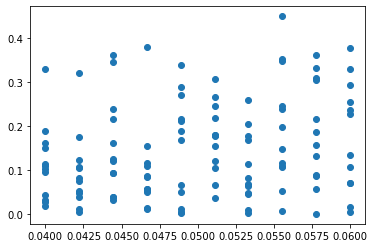

In [72]:
plt.scatter(epsilons.reshape((epsilons_range,1))@np.ones((1,ntrials)), np.abs(bias))

In [73]:
# fit linear model
x = epsilons.reshape((epsilons_range,1))@np.ones((1,ntrials))
linear_fit = sklearn.linear_model.LinearRegression()
linear_fit.fit(x.reshape(-1,1), np.abs(bias).reshape(-1,1))
y = linear_fit.predict(epsilons.reshape(-1,1))

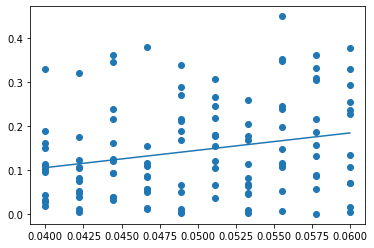

In [74]:
fig, ax = plt.subplots()
ax.scatter(x,np.abs(bias))
ax.plot(epsilons,y)

In [75]:
linear_fit.coef_

array([[3.94523548]])